In [1]:
import pandas as pd
import numpy as np
import pickle
import time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

#from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True
#from rdkit import DataStructs

from pandarallel import pandarallel
from tqdm import tqdm

from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec, mol2sentence
from mol2vec.helpers import depict_identifier, mol_to_svg, IdentifierTable, plot_2D_vectors
from scipy.stats import hypergeom
import collections
import re
pandarallel.initialize(progress_bar = True)
tqdm.pandas()

import umap
import umap.plot
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import joblib
from IPython.core.display import HTML
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
PandasTools.RenderImagesInAllDataFrames(images=True)
from matplotlib_venn import venn2
import matplotlib
import itertools
from itertools import compress
from statsmodels.stats.multitest import fdrcorrection

matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15

# import custom functions
from functions_structural_similarity import *

unable to import 'smart_open.gcs', disabling that module


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/giulia/anaconda/lib/python3.6/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


Giulia Menichetti menicgiulia@gmail.com

# Load Chemical Library and Experimental Outcomes

In [2]:
broad_chems_file=pd.read_csv('../data/cleanbroad_rdkit.csv')

In [3]:
# Classification of the outcomes
broad_chems_file['Outcome'].value_counts()

No-Effect          5657
Low (25%)           308
Very Weak (35%)     241
Weak (50%)          217
Strong (80%)        176
Cyto                110
Name: Outcome, dtype: int64

pert_iname truncated_broadid  \
0              (R)-(-)-apomorphine         K76022557   
1                 (R)-(-)-rolipram         K75516118   
2                     (R)-baclofen         K62353271   
3                 (S)-(+)-rolipram         K65856711   
4     [sar9,met(o2)11]-substance-p         K89787693   
...                            ...               ...   
6704                  zoxazolamine         K66353228   
6705                      ZSET1446         K35984734   
6706                      ZSTK-474         K63068307   
6707                zuclopenthixol         K28761384   
6708                    zuranolone         K00003448   

                                           rdkit_smiles  \
0                 CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3   
1                  COc1ccc([C@@H]2CNC(=O)C2)cc1OC1CCCC1   
2                          NC[C@H](CC(=O)O)c1ccc(Cl)cc1   
3                   COc1ccc([C@H]2CNC(=O)C2)cc1OC1CCCC1   
4     CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...   
...                                                 ...   
6704                                 Nc1nc2cc(Cl)ccc2o1   
6705                     O=C1N=C2C=CC=CN2C12Cc1ccccc1C2   
6706    FC(F)c1nc2ccccc2n1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1   
6707        OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(Cl)cc32)CC1   
6708  C[C@]12CC[C@@H]3[C@H]4CC[C@@](C)(O)C[C@H]4CC[C...   

                   rdkit_InChIKey          Outcome  \
0     VMWNQDUVQKEIOC-CYBMUJFWSA-N        No-Effect   
1     HJORMJIFDVBMOB-LBPRGKRZSA-N        No-Effect   
2     KPYSYYIEGFHWSV-QMMMGPOBSA-N        No-Effect   
3     HJORMJIFDVBMOB-GFCCVEGCSA-N        No-Effect   
4     OUPXSLGGCPUZJJ-SARDKLJWSA-N        No-Effect   
...                           ...              ...   
6704  YGCODSQDUUUKIV-UHFFFAOYSA-N  Very Weak (35%)   
6705  QZWYXEBIQWJXAR-UHFFFAOYSA-N        No-Effect   
6706  HGVNLRPZOWWDKD-UHFFFAOYSA-N        No-Effect   
6707  WFPIAZLQTJBIFN-DVZOWYKESA-N        No-Effect   
6708  HARRKNSQXBRBGZ-GVKWWOCJSA-N        No-Effect   

                                               Molecule  
0     <img data-content="rdkit/molecule" src="data:i...  
1     <img data-content="rdkit/molecule" src="data:i...  
2     <img data-content="rdkit/molecule" src="data:i...  
3     <img data-content="rdkit/molecule" src="data:i...  
4     <img data-content="rdkit/molecule" src="data:i...  
...                                                 ...  
6704  <img data-content="rdkit/molecule" src="data:i...  
6705  <img data-content="rdkit/molecule" src="data:i...  
6706  <img data-content="rdkit/molecule" src="data:i...  
6707  <img data-content="rdkit/molecule" src="data:i...  
6708  <img data-content="rdkit/molecule" src="data:i...  

[6709 rows x 6 columns]
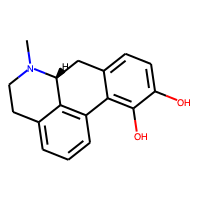
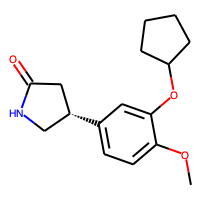
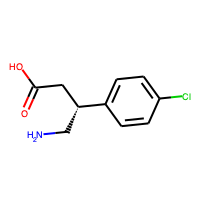
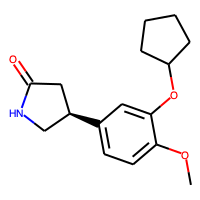
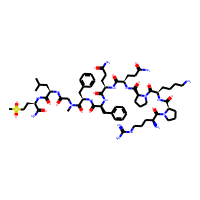
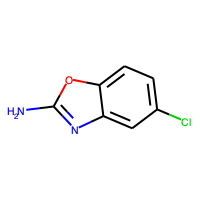
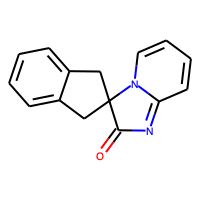
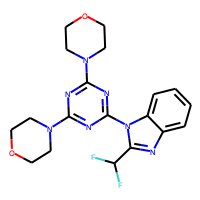
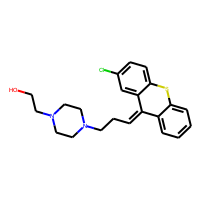
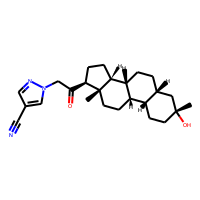

In [4]:
# visualize molecules
PandasTools.AddMoleculeColumnToFrame(broad_chems_file,'rdkit_smiles','Molecule',includeFingerprints=True)
broad_chems_file

# Generate Fingerprints: Radius 3 - 8,192 Bits

In [5]:
broad_chems_file['binary_f'] = broad_chems_file['rdkit_smiles'].progress_apply(get_binary_representation,radius = 3, nBits=8192)
broad_chems_file['count_f'] = broad_chems_file['rdkit_smiles'].progress_apply(get_count_representation,radius = 3, nBits=8192)
broad_chems_file['len_bit'] = broad_chems_file['rdkit_smiles'].progress_apply(get_binary_representation,radius = 3, nBits=8192).apply(np.sum)
broad_chems_file['bit_info'] = broad_chems_file['rdkit_smiles'].progress_apply(get_bit_info,radius = 3, nBits=8192)

100%|██████████| 6709/6709 [00:02<00:00, 2539.49it/s]


# Generate Colormap for Experimental Outcomes

In [6]:
# colormap
cmapdict={'No-Effect': (179/255,226/255,205/255), 
'Low (25%)': (102/255,194/255,165/255),
'Very Weak (35%)': (27/255,158/255,119/255),          
'Weak (50%)': (231/255,41/255,138/255),          
'Strong (80%)': (117/255,112/255,179/255),          
'Cyto':(217/255,95/255,2/255)
}
row_colors=list(broad_chems_file['Outcome'].map(cmapdict))

In [7]:
# reordering of the db 
ordered_classes = list(cmapdict.keys())
df_list = [broad_chems_file[broad_chems_file['Outcome']==i] for i in ordered_classes]
ordered_df = pd.concat(df_list)

# Figures Bit Representation Morgan Fingerprint

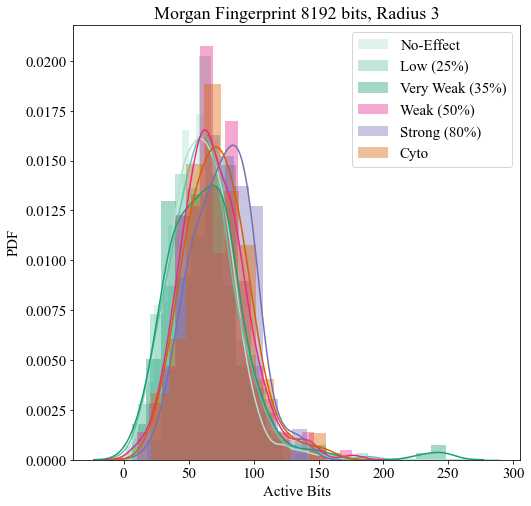

In [8]:
plt.figure(figsize = (8, 8))
for target in ordered_classes:
    sns.distplot(ordered_df.loc[ordered_df['Outcome']==target,'len_bit'], label=target, color=cmapdict[target])
    
plt.legend()
plt.xlabel('Active Bits')
plt.ylabel('PDF');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/activebits.png', dpi=600, bbox_inches = 'tight')

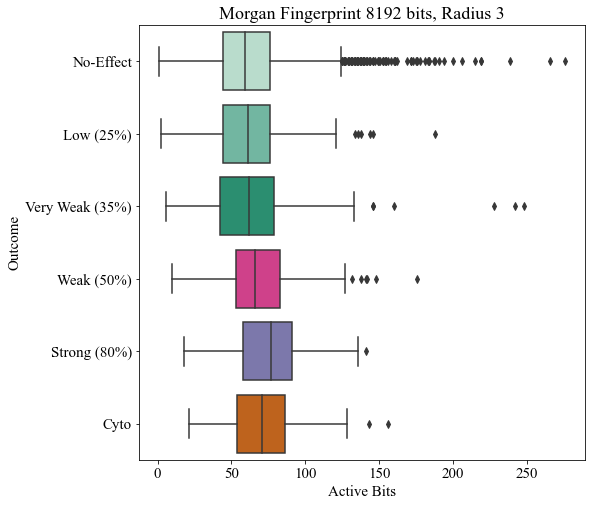

In [9]:
plt.figure(figsize = (8, 8))
ax = sns.boxplot(y='Outcome', x='len_bit', data=ordered_df, orient="h", palette=cmapdict)
plt.xlabel('Active Bits');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/activebitsboxplots.png', dpi=600, bbox_inches = 'tight')

# Binary Structural Matrix and UMAP Dimensionality Reduction With Jaccard Metric

In [10]:
Embeddings=np.array([np.array(xi) for xi in broad_chems_file['binary_f']])
nc=Embeddings.shape[0]
nf=Embeddings.shape[1]
kf=Embeddings.sum(axis=0)
print(Embeddings.shape)

(6709, 8192)


In [11]:
# 3D space with Jaccard metric
reducer = umap.UMAP(n_components=3, metric='jaccard')
umapcoord = reducer.fit_transform(Embeddings)

/Users/giulia/anaconda/lib/python3.6/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/Users/giulia/anaconda/lib/python3.6/site-packages/pynndescent/rp_trees.py:747: NumbaTypeSafetyWarning: unsafe cast from UniTuple(int64 x 2) to UniTuple(int32 x 2). Precision may be lost.
  leaf_size,


pert_iname truncated_broadid  \
0              (R)-(-)-apomorphine         K76022557   
1                 (R)-(-)-rolipram         K75516118   
2                     (R)-baclofen         K62353271   
3                 (S)-(+)-rolipram         K65856711   
4     [sar9,met(o2)11]-substance-p         K89787693   
...                            ...               ...   
6704                  zoxazolamine         K66353228   
6705                      ZSET1446         K35984734   
6706                      ZSTK-474         K63068307   
6707                zuclopenthixol         K28761384   
6708                    zuranolone         K00003448   

                                           rdkit_smiles  \
0                 CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3   
1                  COc1ccc([C@@H]2CNC(=O)C2)cc1OC1CCCC1   
2                          NC[C@H](CC(=O)O)c1ccc(Cl)cc1   
3                   COc1ccc([C@H]2CNC(=O)C2)cc1OC1CCCC1   
4     CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...   
...                                                 ...   
6704                                 Nc1nc2cc(Cl)ccc2o1   
6705                     O=C1N=C2C=CC=CN2C12Cc1ccccc1C2   
6706    FC(F)c1nc2ccccc2n1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1   
6707        OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(Cl)cc32)CC1   
6708  C[C@]12CC[C@@H]3[C@H]4CC[C@@](C)(O)C[C@H]4CC[C...   

                   rdkit_InChIKey          Outcome  \
0     VMWNQDUVQKEIOC-CYBMUJFWSA-N        No-Effect   
1     HJORMJIFDVBMOB-LBPRGKRZSA-N        No-Effect   
2     KPYSYYIEGFHWSV-QMMMGPOBSA-N        No-Effect   
3     HJORMJIFDVBMOB-GFCCVEGCSA-N        No-Effect   
4     OUPXSLGGCPUZJJ-SARDKLJWSA-N        No-Effect   
...                           ...              ...   
6704  YGCODSQDUUUKIV-UHFFFAOYSA-N  Very Weak (35%)   
6705  QZWYXEBIQWJXAR-UHFFFAOYSA-N        No-Effect   
6706  HGVNLRPZOWWDKD-UHFFFAOYSA-N        No-Effect   
6707  WFPIAZLQTJBIFN-DVZOWYKESA-N        No-Effect   
6708  HARRKNSQXBRBGZ-GVKWWOCJSA-N        No-Effect   

                                               Molecule    coord1     coord2  \
0     <img data-content="rdkit/molecule" src="data:i...  2.161366  10.907268   
1     <img data-content="rdkit/molecule" src="data:i...  1.459225  10.714555   
2     <img data-content="rdkit/molecule" src="data:i...  2.401899  10.160418   
3     <img data-content="rdkit/molecule" src="data:i...  1.467942  10.727603   
4     <img data-content="rdkit/molecule" src="data:i...  4.460646  12.749426   
...                                                 ...       ...        ...   
6704  <img data-content="rdkit/molecule" src="data:i...  1.176159   9.911860   
6705  <img data-content="rdkit/molecule" src="data:i...  0.906809  12.228574   
6706  <img data-content="rdkit/molecule" src="data:i... -0.889275  10.196002   
6707  <img data-content="rdkit/molecule" src="data:i... -0.049610  12.197359   
6708  <img data-content="rdkit/molecule" src="data:i...  9.299988   9.318083   

        coord3  
0     5.181870  
1     8.630066  
2     7.833555  
3     8.602666  
4     6.259000  
...        ...  
6704  8.093158  
6705  6.023759  
6706  7.644978  
6707  6.068541  
6708  8.599302  

[6709 rows x 9 columns]
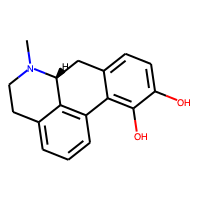
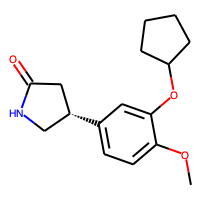
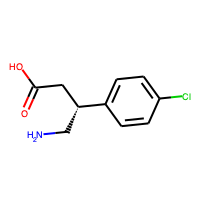
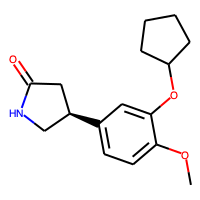
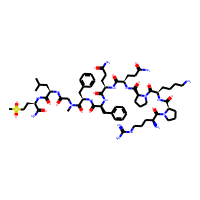
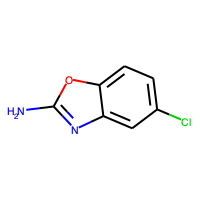
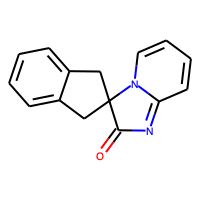
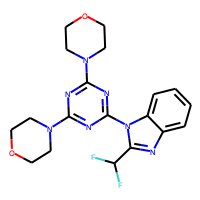
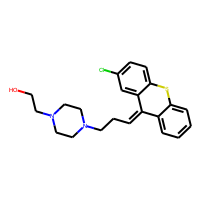
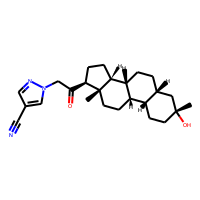

In [12]:
dfexport=broad_chems_file.loc[:,'pert_iname':'Molecule'].copy()
dfexport['coord1']=umapcoord[:,0]
dfexport['coord2']=umapcoord[:,1]
dfexport['coord3']=umapcoord[:,2]
specifics='Jaccard_Binary_8192b_R3'
dfexport.to_pickle('../data/Broad_Outcomes_Keys_with_fingerprint_embedding'+specifics+'.pkl')
dfexport

[('No-Effect', 5657), ('Low (25%)', 308), ('Very Weak (35%)', 241), ('Weak (50%)', 217), ('Strong (80%)', 176), ('Cyto', 110)]


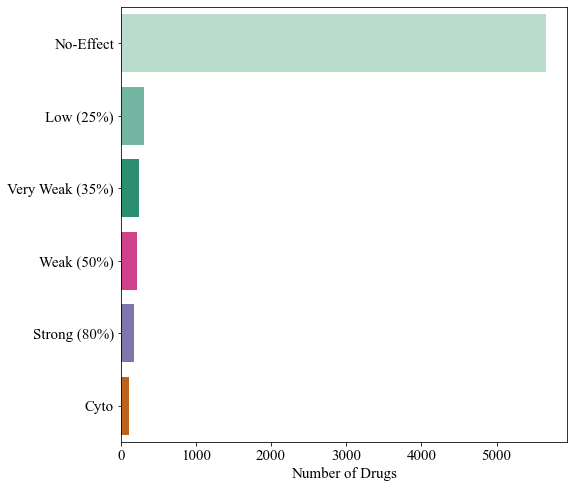

In [13]:
#Counts 
counterST=collections.Counter(broad_chems_file['Outcome'])
counterSTkey=sorted(counterST, key=counterST.get, reverse=True)
counttypes=[counterST[k] for k in counterSTkey]
print([(k, counterST[k]) for k in counterSTkey])

plt.figure(figsize = (8, 8))
ax = sns.barplot(x = counttypes, y=counterSTkey, palette=cmapdict)
ax.set_ylabel('')
ax.set_xlabel('Number of Drugs')
plt.savefig('../figs/drugcounts.png', dpi=600, bbox_inches = 'tight')

# Jaccard Similarity Matrix

In [14]:
matdist=squareform(pdist(Embeddings, 'jaccard'))
matsim = 1 - matdist
dfsim = pd.DataFrame(data=matsim, index=broad_chems_file['pert_iname'], columns=broad_chems_file['pert_iname'])

In [15]:
# export similarity matrix
dfsim.to_csv('../out/df_structural_similarity.csv')

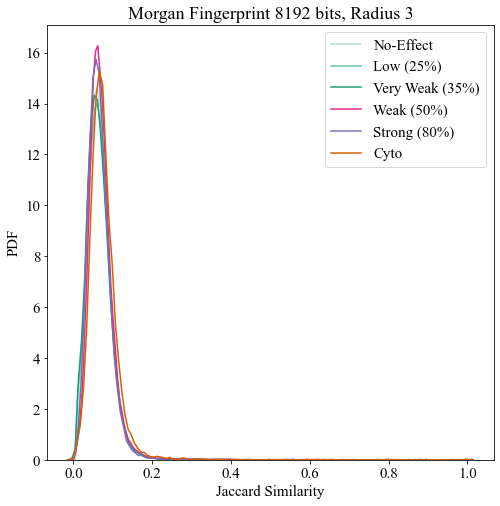

In [16]:
plt.figure(figsize = (8, 8))
for lb in ordered_classes:
    msel=squareform(matdist[broad_chems_file['Outcome']==lb,:][:,broad_chems_file['Outcome']==lb])
    sns.distplot(1-msel, color=cmapdict[lb], label=lb, hist=False)   

plt.legend()
plt.xlabel('Jaccard Similarity')
plt.ylabel('PDF');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3_Kernel.png', dpi=600, bbox_inches = 'tight')

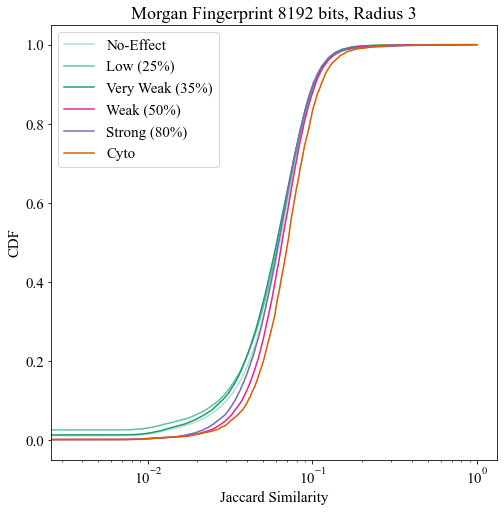

In [17]:
# ECDF
f, ax=plt.subplots(figsize = (8, 8))
ax.set(xscale="log")
for lb in ordered_classes:
    msel=squareform(matdist[broad_chems_file['Outcome']==lb,:][:,broad_chems_file['Outcome']==lb])
    ecdf=ECDF(1-msel)
    sns.lineplot(x=ecdf.x, y=ecdf.y,color=cmapdict[lb], label=lb, ax=ax)   

plt.legend()
plt.xlabel('Jaccard Similarity')
plt.ylabel('CDF');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3CDFlogx.png', dpi=600, bbox_inches = 'tight')

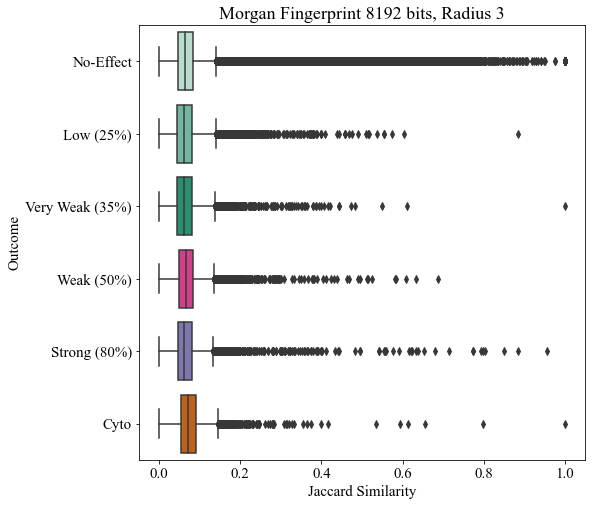

In [18]:
similarityvec=[]
outcomvec=[]

for lb in ordered_classes:
    msel=squareform(matdist[broad_chems_file['Outcome']==lb,:][:,broad_chems_file['Outcome']==lb])
    similarityvec.append(1-msel)
    outcomvec.append([lb for ind in range(len(msel))])
    
similarityvec=list(itertools.chain(*similarityvec))
outcomvec=list(itertools.chain(*outcomvec))

plotdf=pd.DataFrame.from_dict({'Jaccard': similarityvec, 'Outcome': outcomvec})

plt.figure(figsize = (8, 8))
ax = sns.boxplot(y='Outcome', x='Jaccard', data=plotdf, orient="h", palette=cmapdict)
plt.xlabel('Jaccard Similarity');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3BoxPlot.png', dpi=600, bbox_inches = 'tight')

# Clustermap of Similarity Matrix and Selection

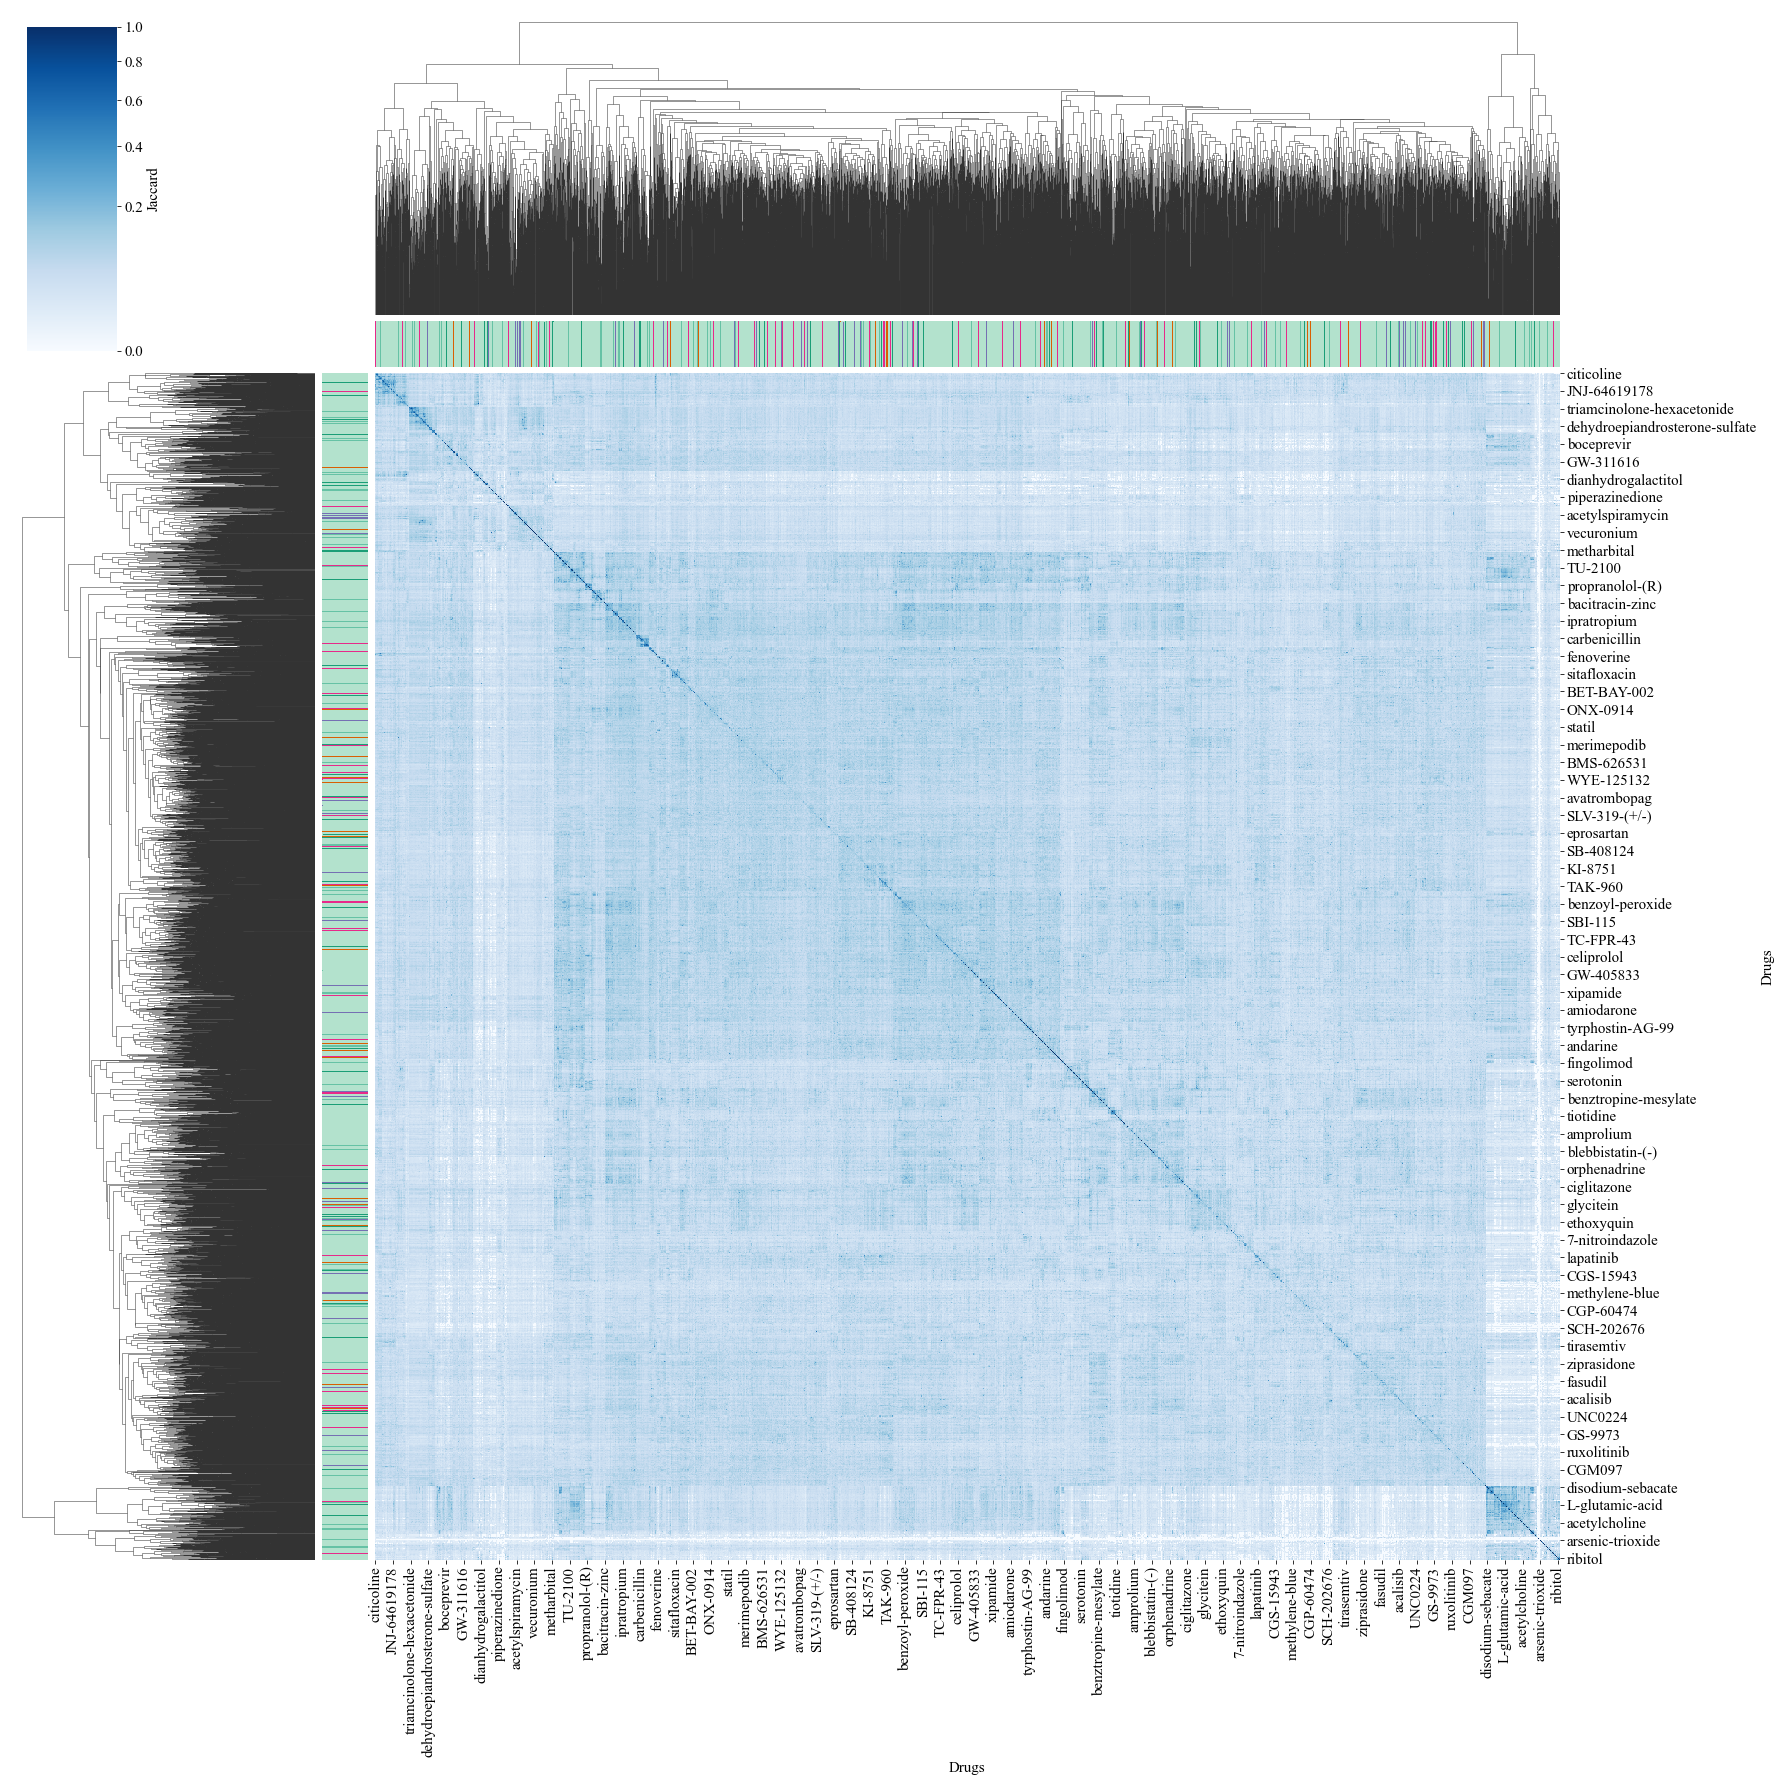

In [19]:
dfplot=pd.DataFrame(matsim, index=broad_chems_file['pert_iname'], columns=broad_chems_file['pert_iname'])
g = sns.clustermap(dfplot, row_colors=row_colors,col_colors=row_colors, cmap="Blues",vmin=0, vmax=1,figsize=(25,25), cbar_kws={'label': 'Jaccard'},xticklabels = 100, yticklabels = 100,
                  norm=colors.PowerNorm(gamma=0.5))
ax = g.ax_heatmap
ax.set_xlabel('Drugs');
ax.set_ylabel('Drugs');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3clustermap.png', dpi=600, bbox_inches = 'tight')

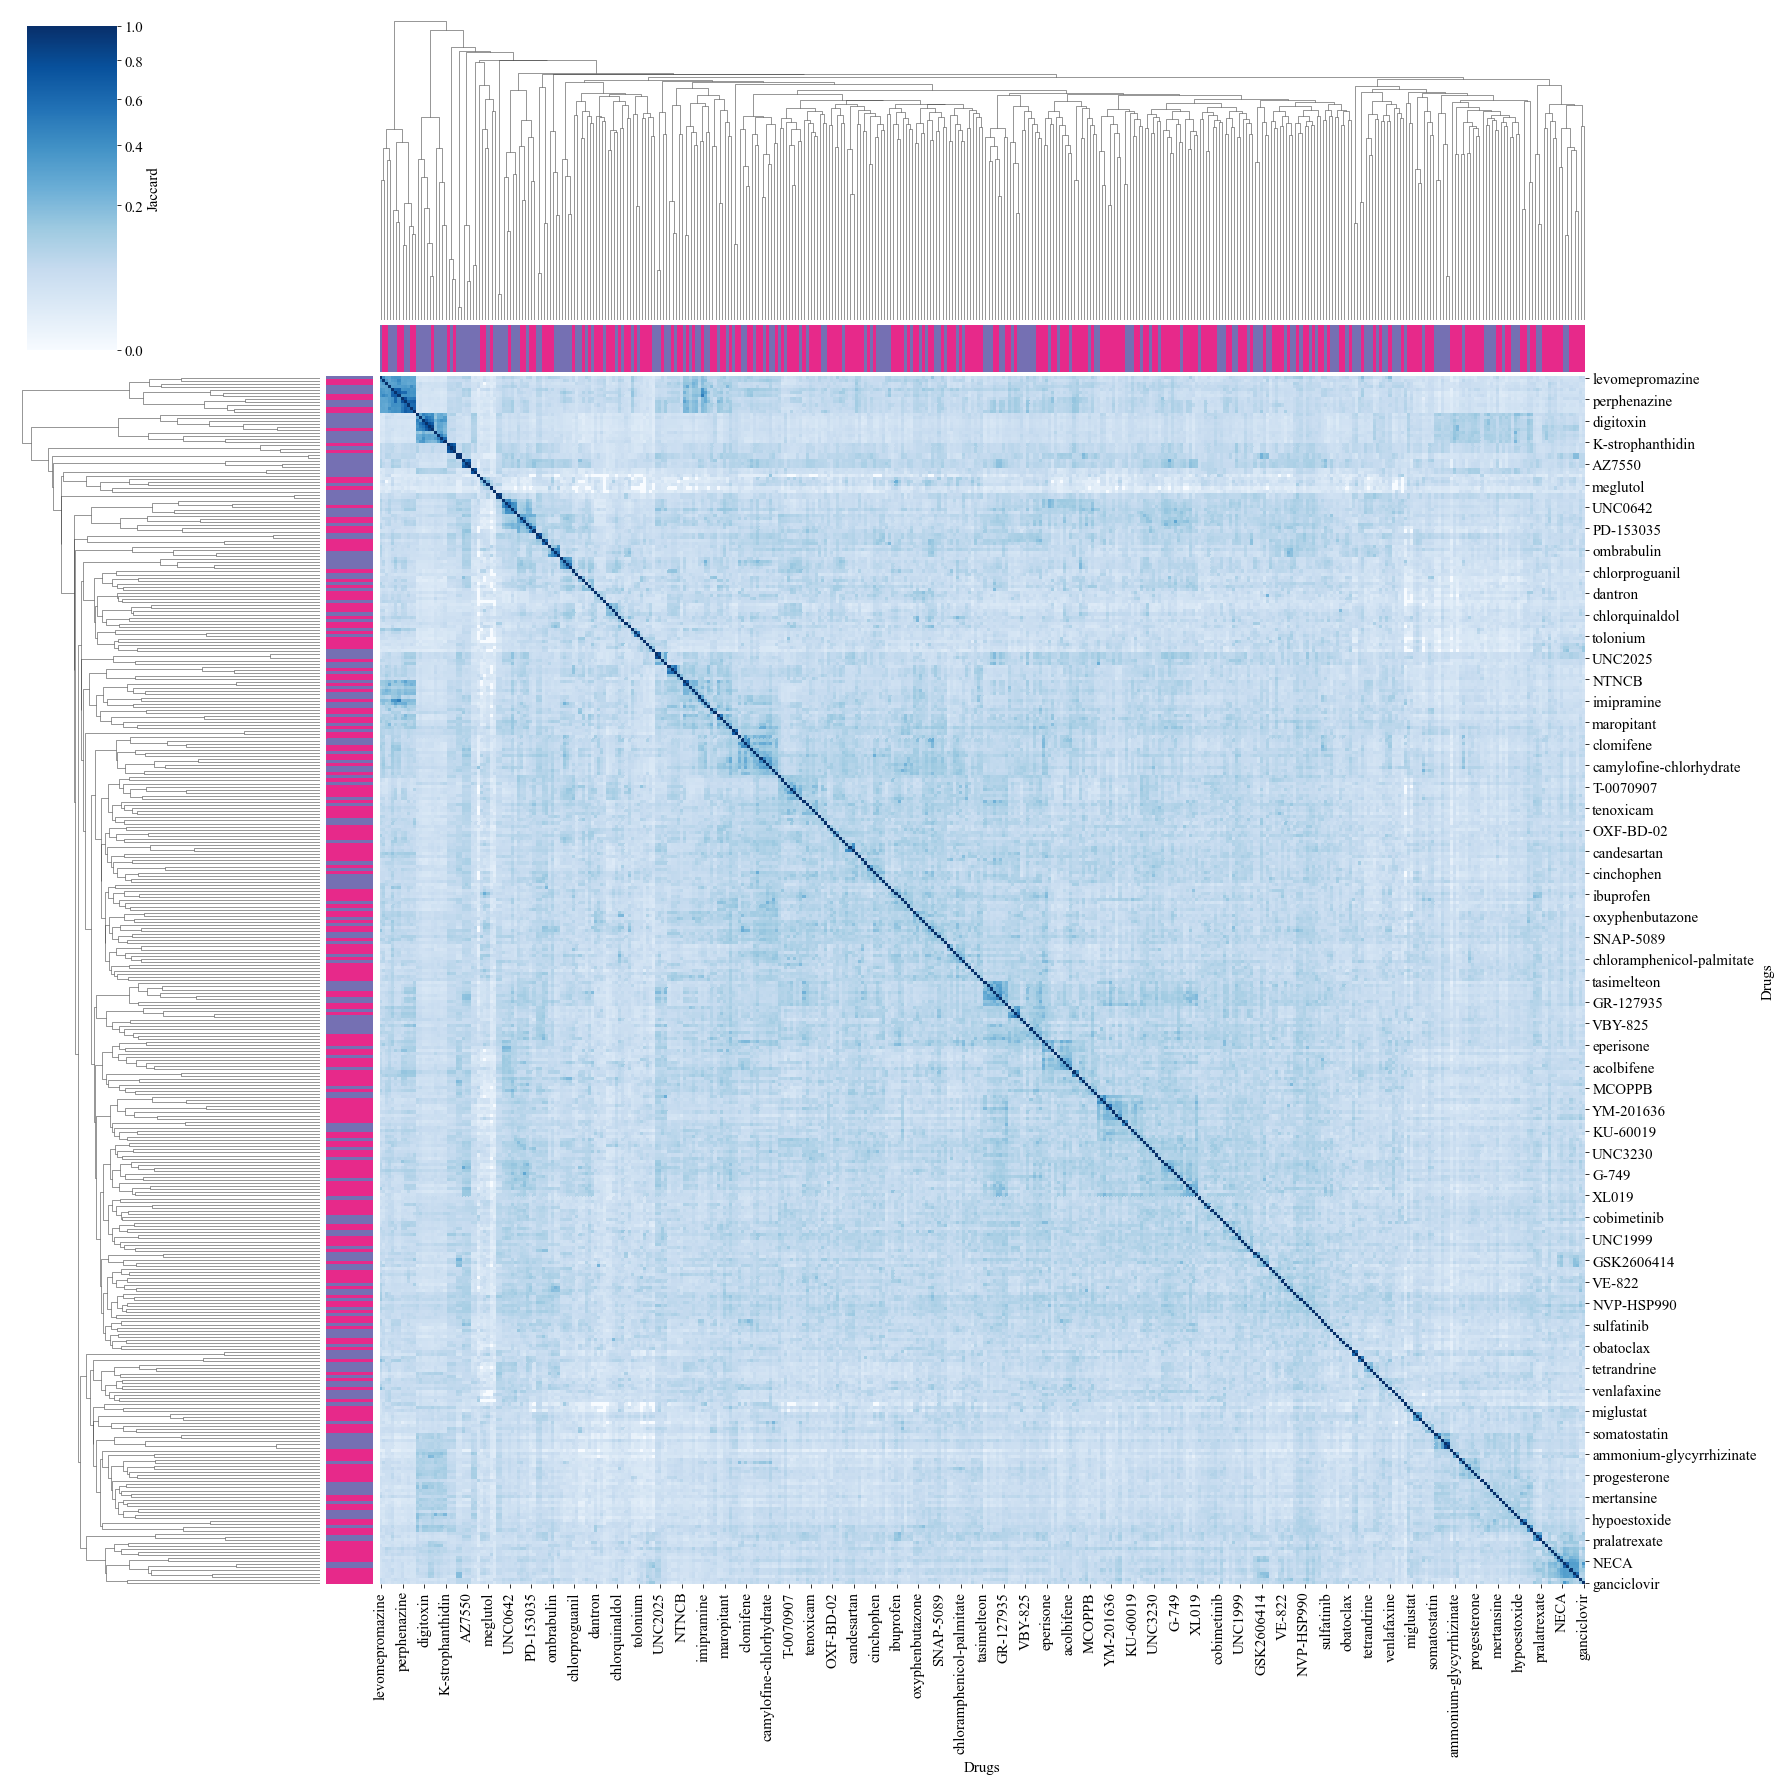

In [20]:
# filter class for Strong-Weak
filterC=broad_chems_file['Outcome'].isin(['Weak (50%)','Strong (80%)'])
dfplot=pd.DataFrame(matsim[filterC,:][:, filterC], index=broad_chems_file['pert_iname'][filterC], columns=broad_chems_file['pert_iname'][filterC])
g=sns.clustermap(dfplot, row_colors=list(compress(row_colors, filterC)),col_colors=list(compress(row_colors, filterC)) , vmin=0, vmax=1, cmap="Blues", figsize=(25,25), cbar_kws={'label': 'Jaccard'},
  norm=colors.PowerNorm(gamma=0.5))
ax = g.ax_heatmap
ax.set_xlabel('Drugs');
ax.set_ylabel('Drugs');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3clustermapWS.png', dpi=600, bbox_inches = 'tight')

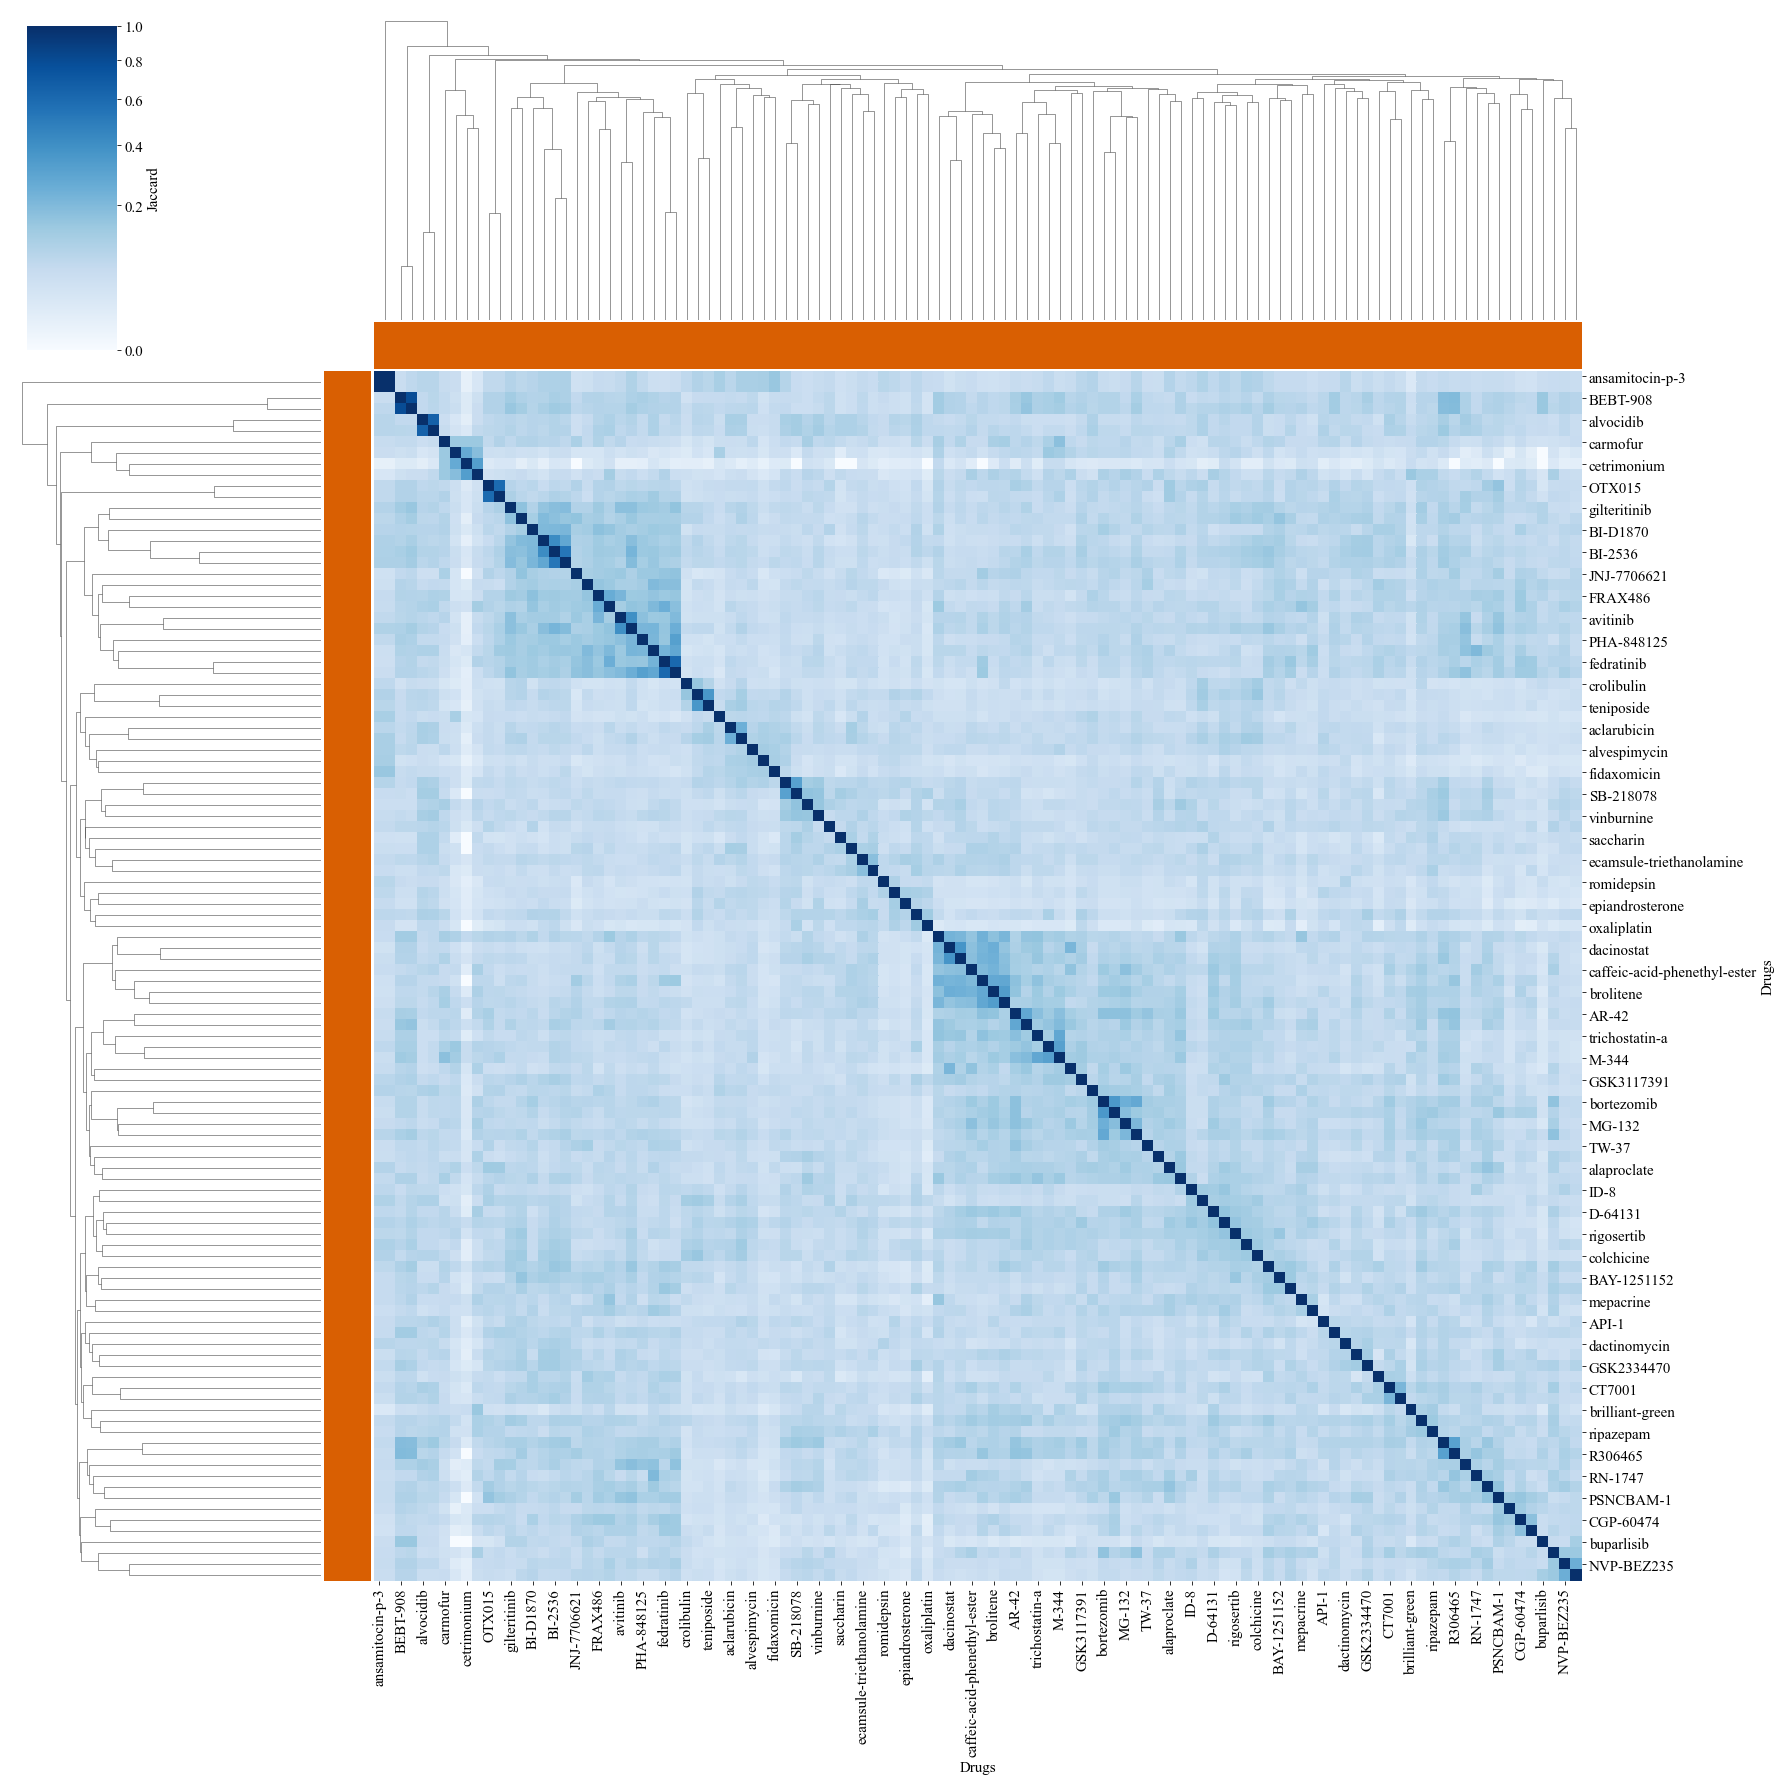

In [21]:
# filter class for Cyto
filterC=broad_chems_file['Outcome'].isin(['Cyto'])
dfplot=pd.DataFrame(matsim[filterC,:][:, filterC], index=broad_chems_file['pert_iname'][filterC], columns=broad_chems_file['pert_iname'][filterC])
g=sns.clustermap(dfplot, row_colors=list(compress(row_colors, filterC)),col_colors=list(compress(row_colors, filterC)) , vmin=0, vmax=1, cmap="Blues", figsize=(25,25), cbar_kws={'label': 'Jaccard'},
                norm=colors.PowerNorm(gamma=0.5))
ax = g.ax_heatmap
ax.set_xlabel('Drugs');
ax.set_ylabel('Drugs');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3clustermapCyto.png', dpi=600, bbox_inches = 'tight')

# Similarity Filter

In [22]:
# filter on similarity matrix according to literature
ts=0.85
matsim = 1 - matdist
filterS=((matsim>ts).sum(axis=0)>1)

print('Number of Drugs in the selection')
print(sum(filterS))

Number of Drugs in the selection
329


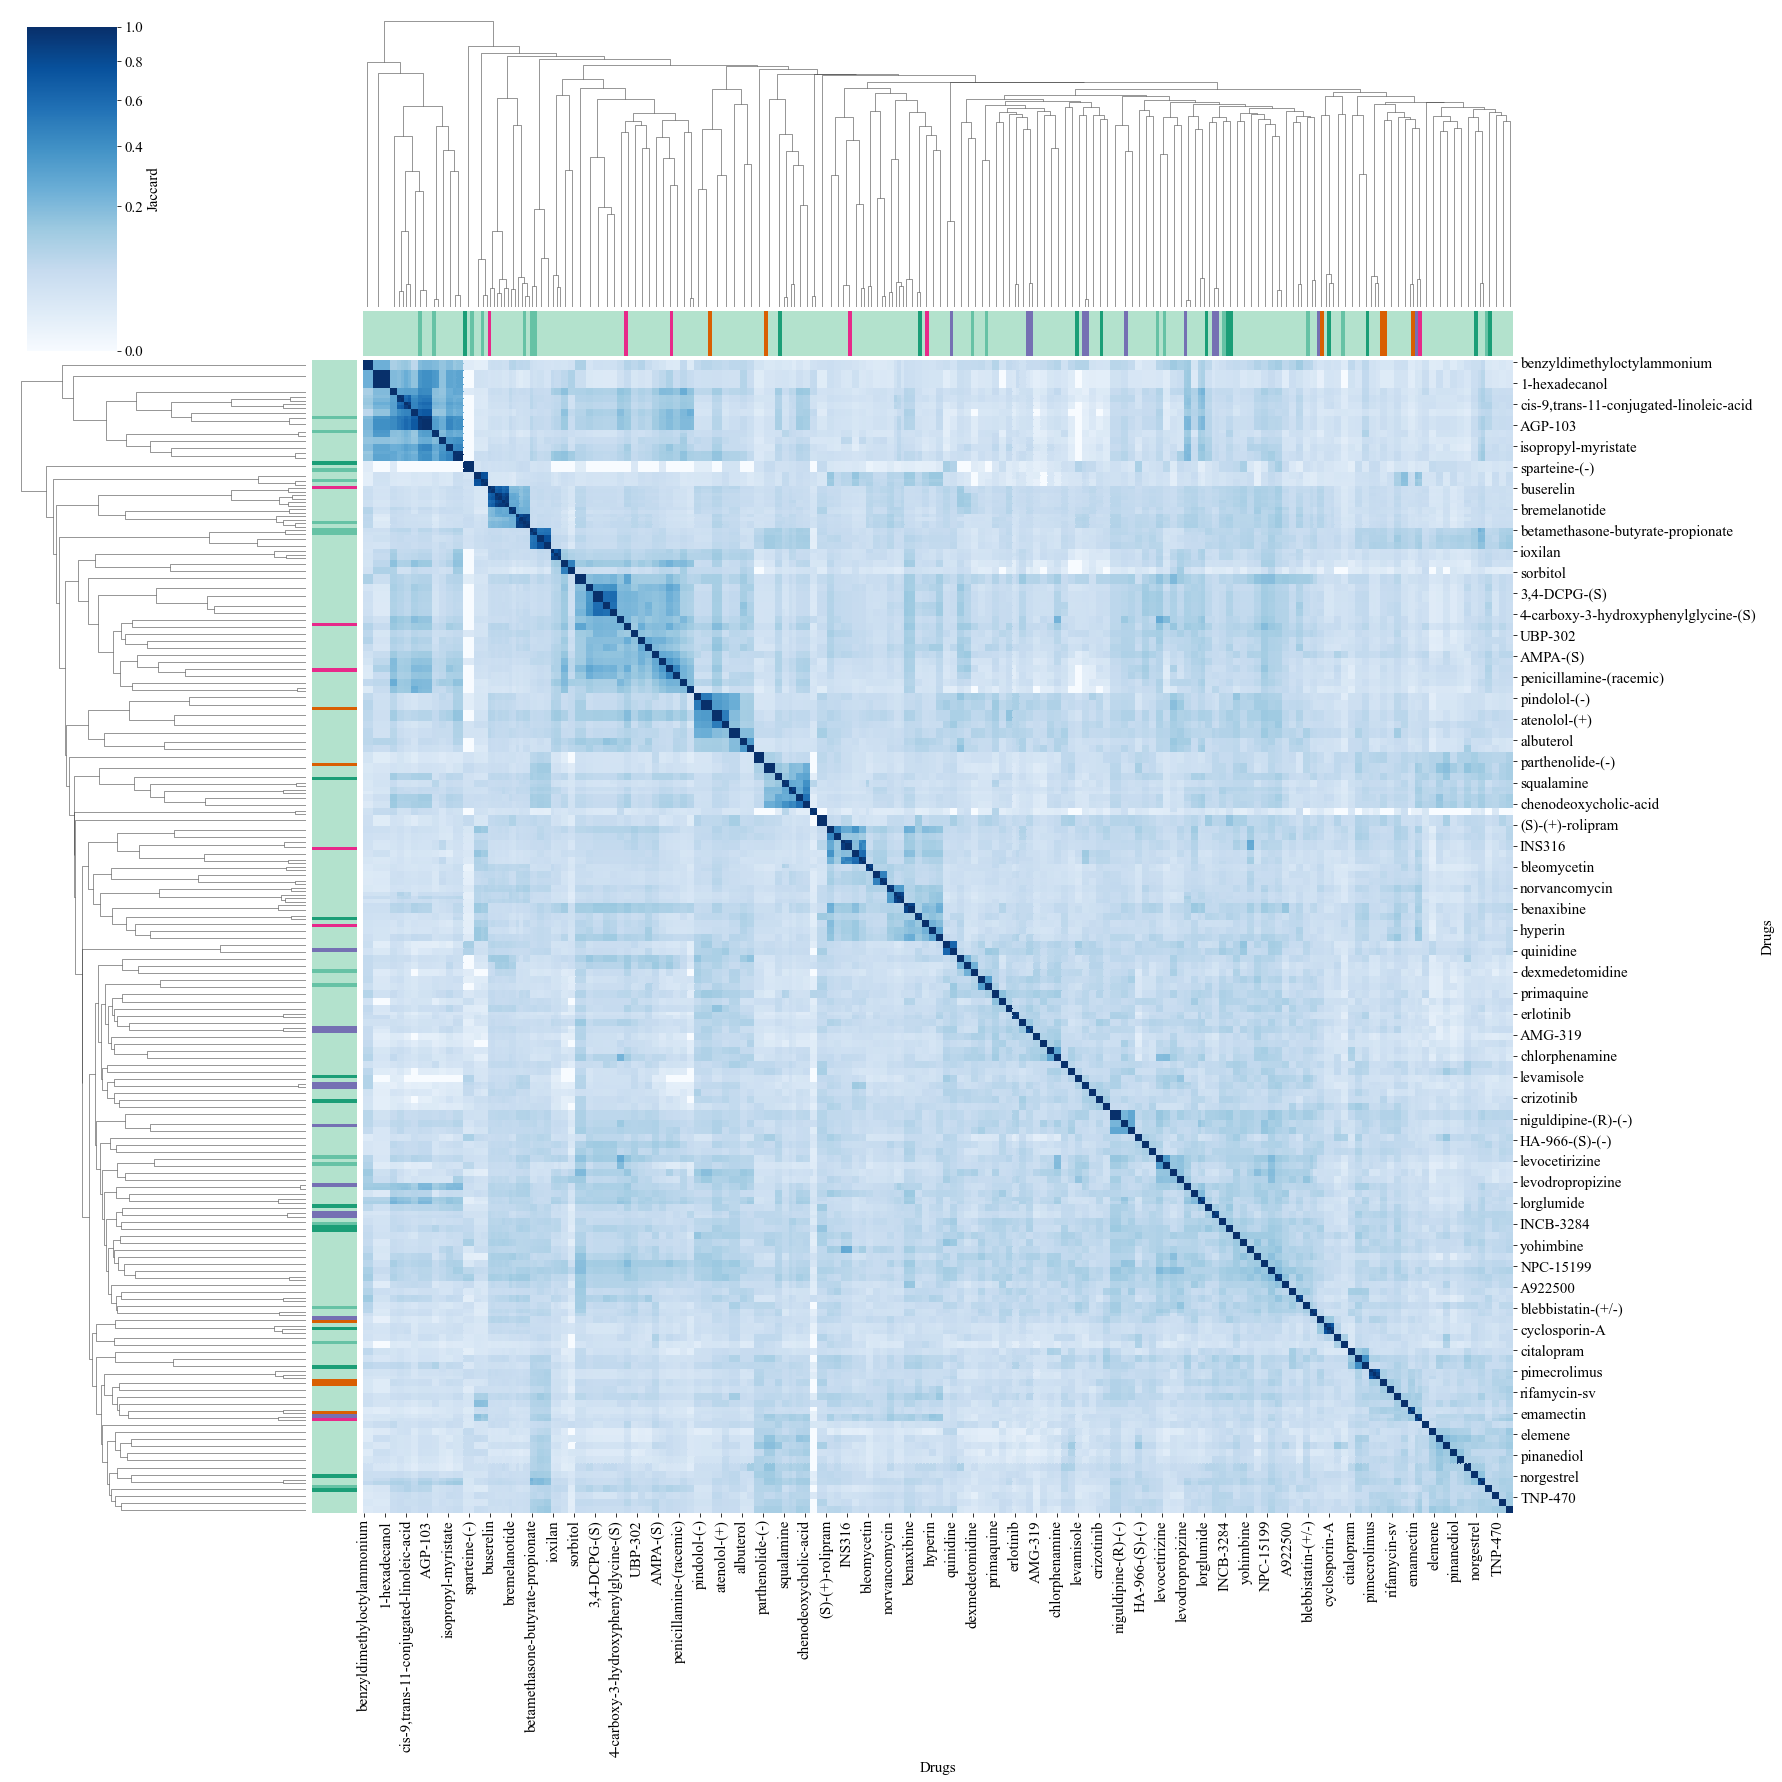

In [23]:
# filter on Similarity Values
dfplot=pd.DataFrame(matsim[filterS,:][:, filterS], index=broad_chems_file['pert_iname'][filterS], columns=broad_chems_file['pert_iname'][filterS])
g=sns.clustermap(dfplot, row_colors=list(compress(row_colors, filterS)),col_colors=list(compress(row_colors, filterS)) , vmin=0, vmax=1, cmap="Blues", figsize=(25,25), cbar_kws={'label': 'Jaccard'},
                norm=colors.PowerNorm(gamma=0.5))
ax = g.ax_heatmap
ax.set_xlabel('Drugs');
ax.set_ylabel('Drugs');
plt.savefig('../figs/JaccardSimilarity8192bitsRadius3clustermapTS085.png', dpi=600, bbox_inches = 'tight')

# Estimated Number of Non Hydrogen Atoms per Bit

In [24]:
#get fragment smiles 
dictbit2fragmentsmiles={}

for biton in range(Embeddings.shape[1]):
    
    listfragmperbit=[]
    for molind in list(Embeddings[:, biton].nonzero()[0]):
        # smile
        smileid=broad_chems_file.iloc[molind]['rdkit_smiles']
        # bitinfo
        bitinfoid=broad_chems_file.iloc[molind]['bit_info']
        #print(bitinfoid)
        
        #unique over the molecule
        setfragsmile={get_smile_fragment(smileid, ai, ri) for (ai, ri) in bitinfoid[biton]}
        listfragmperbit+=list(setfragsmile)
    
    
    # here consider the repetitions
    dictbit2fragmentsmiles[biton]=listfragmperbit   

In [25]:
# size fragments 
avg_fragment_size=[np.mean([NumberAtomsInFragment(sf) for sf in dictbit2fragmentsmiles[bid]]) for bid in range(Embeddings.shape[1])]
std_fragment_size=[np.std([NumberAtomsInFragment(sf) for sf in dictbit2fragmentsmiles[bid]]) for bid in range(Embeddings.shape[1])]

Average Fragment Size
8.722151583150264
Median Fragment Size
9.0


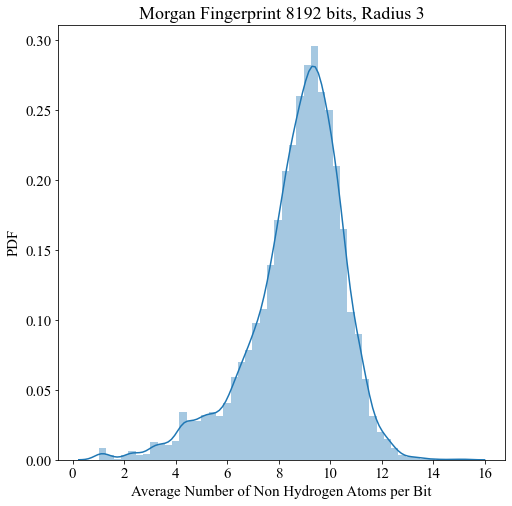

In [26]:
print('Average Fragment Size')
print(np.mean(avg_fragment_size))
print('Median Fragment Size')
print(np.median(avg_fragment_size))



plt.figure(figsize = (8, 8))    
sns.distplot(avg_fragment_size)
plt.xlabel('Average Number of Non Hydrogen Atoms per Bit')
plt.ylabel('PDF');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/NonHydrogenAtoms.png', dpi=600, bbox_inches = 'tight')

# Enrichment in Active Bits

In [27]:
targetclass='Strong (80%)'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_Strong=EmbeddingsSel.sum(axis=0)
pvalfragments_Strong=[hypergeom.sf(kfSel_Strong[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]


targetclass='Weak (50%)'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_Weak=EmbeddingsSel.sum(axis=0)
pvalfragments_Weak=[hypergeom.sf(kfSel_Weak[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]

targetclass='Very Weak (35%)'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_VeryWeak=EmbeddingsSel.sum(axis=0)
pvalfragments_VeryWeak=[hypergeom.sf(kfSel_VeryWeak[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]


targetclass='Low (25%)'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_Low=EmbeddingsSel.sum(axis=0)
pvalfragments_Low=[hypergeom.sf(kfSel_Low[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]


targetclass='Cyto'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_Cyto=EmbeddingsSel.sum(axis=0)
pvalfragments_Cyto=[hypergeom.sf(kfSel_Cyto[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]

targetclass='No-Effect'
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclass,:]
kfSel_NE=EmbeddingsSel.sum(axis=0)
pvalfragments_NE=[hypergeom.sf(kfSel_NE[f]-1, nc, kf[f], counterST[targetclass]) for f in range(nf)]


dpAll=pd.DataFrame({'FragmentsBitId':[f for f in range(nf)],'AvgNumNonHydrogenAtoms':avg_fragment_size,
                    'StdNumNonHydrogenAtoms':std_fragment_size,
                    'countStrong': kfSel_Strong, 'p-valueStrong': pvalfragments_Strong,
                    'countWeak': kfSel_Weak, 'p-valueWeak': pvalfragments_Weak,
                    'countVeryWeak': kfSel_VeryWeak, 'p-valueVeryWeak': pvalfragments_VeryWeak,
                    'countLow': kfSel_Low, 'p-valueLow': pvalfragments_Low,
                    'countCyto': kfSel_Cyto, 'p-valueCyto': pvalfragments_Cyto,
                    'countNE': kfSel_NE, 'p-valueNE': pvalfragments_NE})                   

dpAll.head(50)

FragmentsBitId  AvgNumNonHydrogenAtoms  StdNumNonHydrogenAtoms  \
0                0                8.772727                2.109111   
1                1                7.846154                2.084601   
2                2               10.620690                2.250116   
3                3               10.285714                1.484615   
4                4                9.090909                2.234219   
5                5                4.571429                1.796949   
6                6                9.500000                3.133916   
7                7               10.346154                1.627700   
8                8               11.551724                1.652296   
9                9               10.352941                1.531673   
10              10                8.000000                2.320477   
11              11                7.452381                2.216844   
12              12               10.700000                1.615549   
13              13                3.323210                1.353746   
14              14                6.654321                1.757948   
15              15               10.000000                2.218801   
16              16                8.880000                3.436898   
17              17                9.458333                2.235680   
18              18                9.812500                2.242174   
19              19                9.333333                1.563472   
20              20                9.093023                3.219230   
21              21                8.954545                2.704832   
22              22                9.272727                2.631657   
23              23               10.058824                2.796439   
24              24                9.909091                2.314168   
25              25                6.268519                1.198815   
26              26                6.571429                2.821203   
27              27                7.500000                3.438230   
28              28                6.638889                3.599018   
29              29                9.333333                2.808717   
30              30                9.633333                2.057237   
31              31                9.750000                3.191786   
32              32                7.172840                0.782369   
33              33               11.090909                4.521756   
34              34                7.790698                1.899304   
35              35                9.692308                1.135756   
36              36               10.500000                2.291288   
37              37                8.625000                2.997395   
38              38               10.782609                2.765573   
39              39                6.878049                1.977867   
40              40                9.250000                1.391941   
41              41                4.867692                2.229392   
42              42                8.000000                3.189657   
43              43               10.258065                3.202496   
44              44                7.875000                2.204399   
45              45                8.393939                1.945303   
46              46                8.480000                3.021523   
47              47               10.264706                3.458228   
48              48                9.238095                1.949475   
49              49                9.000000                2.430862   

    countStrong  p-valueStrong  countWeak  p-valueWeak  countVeryWeak  \
0           0.0       1.000000        0.0     1.000000            0.0   
1           4.0       0.086520        1.0     0.879292            4.0   
2           1.0       0.538171        0.0     1.000000            2.0   
3           0.0       1.000000        1.0     0.205673            0.0   
4           0.0       1.000000        0.0     1.000000            1.

# Multiple testing BH Correction

In [28]:
for dc in ['Strong', 'Weak', 'VeryWeak', 'Low', 'Cyto', 'NE']:
    result=fdrcorrection(dpAll['p-value'+dc])
    dpAll['h'+dc+'BH']=result[0]
    dpAll['p-value'+dc+'BH']=result[1]

In [29]:
# export enrichment statistics
dpAll.to_csv('../out/EnrichedBits.csv')

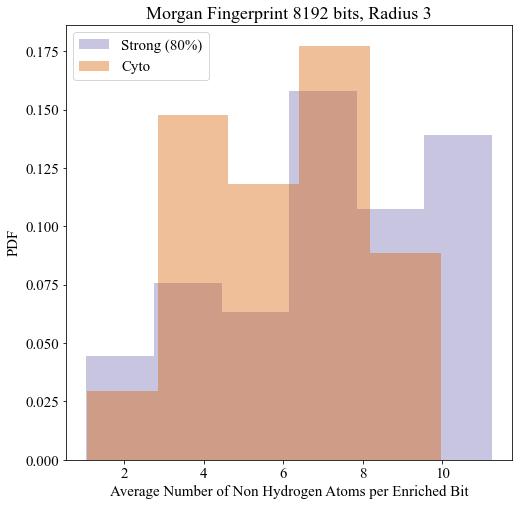

In [30]:
plt.figure(figsize = (8, 8))
lb='Strong (80%)'
sns.distplot(dpAll['AvgNumNonHydrogenAtoms'][dpAll['hStrongBH']], color=cmapdict[lb], label=lb, kde=False, norm_hist=True)  

lb='Cyto'
sns.distplot(dpAll['AvgNumNonHydrogenAtoms'][dpAll['hCytoBH']], color=cmapdict[lb], label=lb, kde=False, norm_hist=True)
 
plt.legend()
plt.xlabel('Average Number of Non Hydrogen Atoms per Enriched Bit')
plt.ylabel('PDF');
plt.title('Morgan Fingerprint 8192 bits, Radius 3');
plt.savefig('../figs/EnrichedBits8192bitsRadius3.png', dpi=600, bbox_inches = 'tight')

# Which bits are significantly active and how they are shared

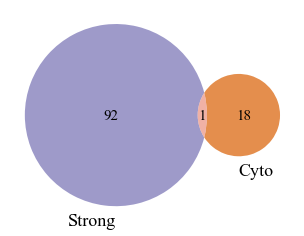

In [31]:
ActiveBitsDict={l:set(dpAll['FragmentsBitId'][dpAll['h'+l+'BH']>0]) for l in ['Strong', 'Weak', 'VeryWeak', 'Low', 'Cyto', 'NE']}
venn2(subsets = (len(ActiveBitsDict['Strong'])-len(ActiveBitsDict['Cyto']&ActiveBitsDict['Strong']), len(ActiveBitsDict['Cyto'])-len(ActiveBitsDict['Cyto']&ActiveBitsDict['Strong']), len(ActiveBitsDict['Cyto']&ActiveBitsDict['Strong'])), set_labels = ('Strong', 'Cyto'), 
      set_colors=(cmapdict['Strong (80%)'],cmapdict['Cyto']), alpha = 0.7);

In [32]:
# which bit in intersection
ActiveBitsDict['Cyto']&ActiveBitsDict['Strong']

{2255}

# Visualize Bits for Experimental Class of Interest

In [33]:
targetclass='Strong'
targetclassfull='Strong (80%)'

filtercol='h'+targetclass+'BH'
# focus on big fragments
filterbit=(dpAll[filtercol]>0)&(dpAll['AvgNumNonHydrogenAtoms']>np.median(avg_fragment_size))
#filterbit=(dpAll[filtercol]>0)

selvectorbit=dpAll[['FragmentsBitId', 'p-value'+targetclass]][filterbit].sort_values(by=['p-value'+targetclass])['FragmentsBitId']
bit2pvalBH={b:p for (b,p) in dpAll[['FragmentsBitId', 'p-value'+targetclass+'BH']][filterbit].values}



# bits selected 
selbittable=dpAll.loc[filterbit,'FragmentsBitId']
EmbeddingsSel=Embeddings[broad_chems_file['Outcome']==targetclassfull,:][:,filterbit]
dbchemsel=broad_chems_file[broad_chems_file['Outcome']==targetclassfull]
print('Bit selected')
print(selbittable.shape[0])
print('Chem selected')
print(dbchemsel.shape[0])
print('Embeddings shape')
print(EmbeddingsSel.shape)

Bit selected
24
Chem selected
176
Embeddings shape
(176, 24)


In [34]:
dictfragmentsmiles={}
dictbit2fragment={}
dictbit2fragment_wr={}

for ind in range(len(selbittable)):
    biton=selbittable.iloc[ind]

    listfragmperbit=[]
    for molind in list(EmbeddingsSel[:, ind].nonzero()[0]):
        smileid=dbchemsel.iloc[molind]['rdkit_smiles']
        # bitinfo
        bitinfoid=dbchemsel.iloc[molind]['bit_info']
        
        #dictfragmentsmiles[(biton, smileid)]={get_smile_fragment(smileid, ai, ri) for (ai, ri) in bitinfoid[biton]}
        setfragsmile={get_smile_fragment(smileid, ai, ri) for (ai, ri) in bitinfoid[biton]}
        dictfragmentsmiles[(biton, smileid)]='  '.join(setfragsmile)
        listfragmperbit+=list(setfragsmile)

            
    dictbit2fragment_wr[biton]=listfragmperbit       
    dictbit2fragment[biton]=set(listfragmperbit)            

In [35]:
print('Total number of fragment smiles')
print(len(list(itertools.chain.from_iterable(list(dictbit2fragment.values())))))
print('Number of fragments per bit')
print(collections.Counter([len(dictbit2fragment[k]) for k in dictbit2fragment]))
print('Median')
print(np.median(np.array([len(dictbit2fragment[k]) for k in dictbit2fragment])))

Total number of fragment smiles
62
Number of fragments per bit
Counter({3: 8, 1: 6, 2: 5, 4: 3, 5: 2})
Median
3.0


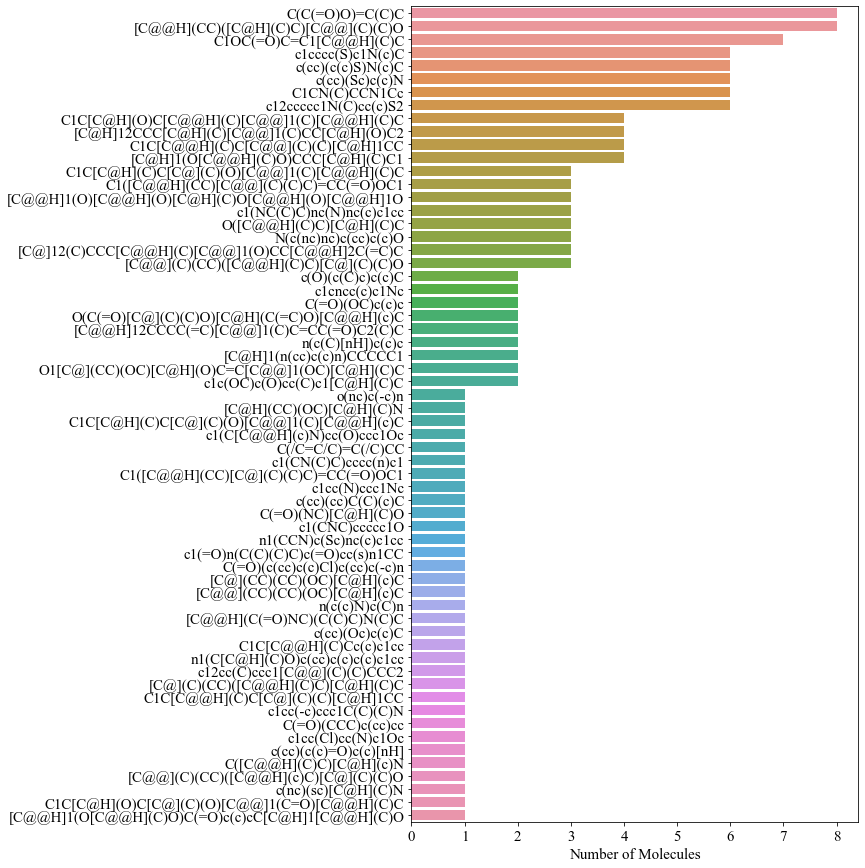

In [36]:
# Most represented fragments
#Counts 
counterF=collections.Counter(list(itertools.chain.from_iterable(list(dictbit2fragment_wr.values()))))
counterFkey=sorted(counterF, key=counterF.get, reverse=True)
counttypes=[counterF[k] for k in counterFkey]
#print([(k, counterF[k]) for k in counterFkey])

plt.figure(figsize = (8, 15))
ax = sns.barplot(x = counttypes, y=counterFkey)
ax.set_ylabel('')
ax.set_xlabel('Number of Molecules');

In [37]:
# create database to export
klist=list(dictfragmentsmiles.keys())
BitList=[k[0] for k in klist]
MoleculeSmileList=[k[1] for k in klist]
nHa=[np.mean([NumberAtomsInFragment(f) for f in dictfragmentsmiles[k].split(' ')]) for k in klist]
pvalBHcol=[bit2pvalBH[k] for k in BitList]
MoleculeFragmentsSmileList=[dictfragmentsmiles[k] for k in klist]



dpfragmentexport=pd.DataFrame.from_dict({'BitInd': BitList, 'MoleculeSmile': MoleculeSmileList,
                                        'FragmentsSmile':MoleculeFragmentsSmileList, 'NonHydrogenAtoms': nHa,
                                        'p-valueBH': pvalBHcol})
print(dpfragmentexport.shape)

dpfragmentexport=dpfragmentexport.sort_values(by=['p-valueBH'])
dpfragmentexport=dpfragmentexport.set_index(pd.Index([k for k in range(dpfragmentexport.shape[0])]))
dpfragmentexport

(144, 5)


BitInd                                      MoleculeSmile  \
0      4409  C[C@]12CC[C@H]3[C@@H](CC[C@]4(O)C[C@@H](O)CC[C...   
1      4409  C[C@@H]1O[C@@H](O[C@@H]2C[C@@H](O)[C@]3(CO)[C@...   
2      4409  CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C)[C@H]4CC[C@]5(...   
3      4409  C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...   
4      4409  C[C@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@@H]2C[C@@H...   
..      ...                                                ...   
139    2391  CN1CCN(CCCN2c3ccccc3Sc3ccc(S(=O)(=O)N(C)C)cc32...   
140    2391             CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1   
141    2391          COc1ccc2c(c1)N(C[C@H](C)CN(C)C)c1ccccc1S2   
142    2391                   CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21   
143    2391             CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2   

       FragmentsSmile  NonHydrogenAtoms     p-valueBH  
0     C(C(=O)O)=C(C)C               7.0  6.574287e-08  
1     C(C(=O)O)=C(C)C               7.0  6.574287e-08  
2     C(C(=O)O)=C(C)C               7.0  6.574287e-08  
3     C(C(=O)O)=C(C)C               7.0  6.574287e-08  
4     C(C(=O)O)=C(C)C               7.0  6.574287e-08  
..                ...               ...           ...  
139  c1cccc(S)c1N(c)C              10.0  4.821135e-02  
140  c1cccc(S)c1N(c)C              10.0  4.821135e-02  
141  c1cccc(S)c1N(c)C              10.0  4.821135e-02  
142  c1cccc(S)c1N(c)C              10.0  4.821135e-02  
143  c1cccc(S)c1N(c)C              10.0  4.821135e-02  

[144 rows x 5 columns]

In [38]:
# generate svg files
count=0
dictfragmentpic={}
stringfilewhole=[]

for biton,smileid in dpfragmentexport[['BitInd', 'MoleculeSmile']].values:
    bitinfoid=get_bit_info(smileid)
    
    svg=depictBit(biton,smileid,molSize=(500,500),radius = 3, nBits=8192)
    dictfragmentpic[(biton, smileid)]=svg
    
    file='../figs/'+targetclass+str(count)+'.svg'
            
    with open(file, 'w') as f:
        f.write(svg.data)
                
    stringfilewhole.append(file)   
    count+=1

dpfragmentexport['WholeMolHighlighted']=stringfilewhole

In [39]:
# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="200" height="200">'


pd.set_option('display.max_colwidth', None)

# visualize HTML
HTML(dpfragmentexport.to_html(escape=False ,formatters=dict(WholeMolHighlighted=path_to_image_html)))

In [40]:
with open('../out/'+targetclass+'_BitEnrichment.html', 'w') as fo:
    fo.write(dpfragmentexport.to_html(escape=False ,formatters=dict(WholeMolHighlighted=path_to_image_html)))  